pyFFTW not found, using Numpy FT.


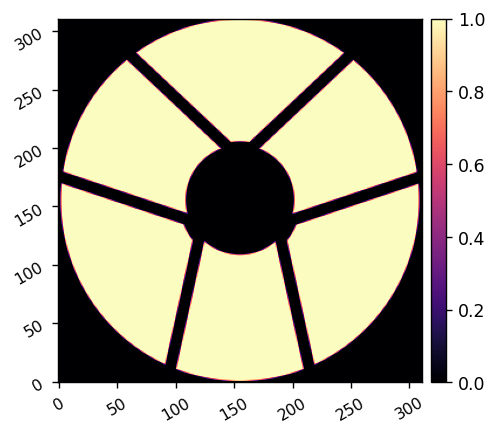

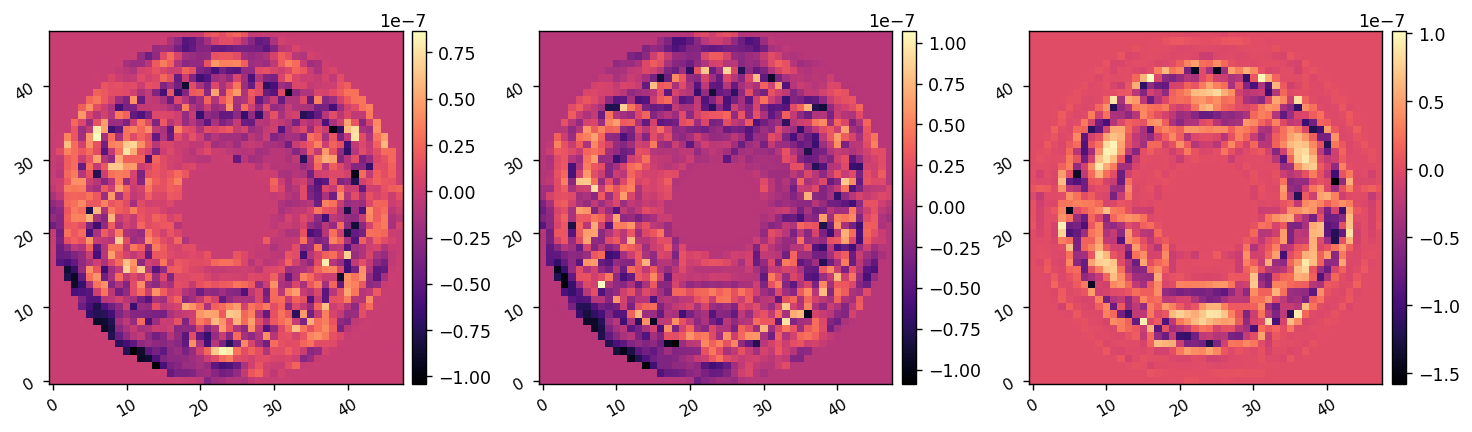

In [1]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from IPython.display import clear_output, display
import time
from pathlib import Path
import copy

import proper
proper.prop_use_fftw(DISABLE=False)

import roman_phasec_proper

import cgi_phasec_poppy as cgi
import cgi_phasec_poppy.imshows as imshows
from cgi_phasec_poppy.imshows import *
import ray

from importlib import reload

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')
data_dir = Path('/npool/nvme/kianmilani/disk-data')

pupil = fits.getdata(roman_phasec_proper.data_dir + '/hlc_20190210b/pupil.fits')
npup = pupil.shape[0]
imshow1(pupil)

dm1_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm1.fits')
dm2_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm2.fits')
imshow3(dm1_best, dm2_best, dm1_best-dm2_best)

# Generate Distribution of PRFs

11089

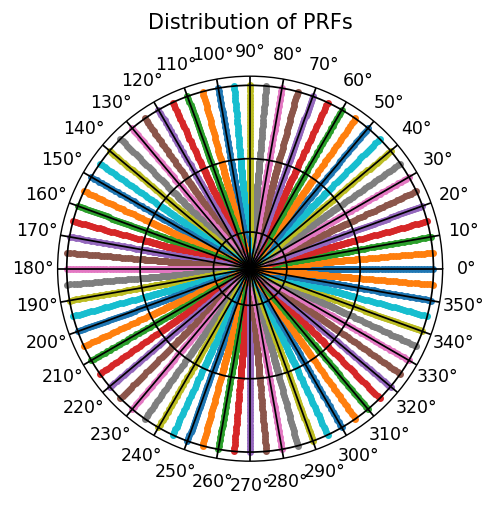

In [3]:
wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

npsf = 64
psf_pixelscale = 13e-6
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

iwa = 3
owa = 9

# Create the sampling grid the PSFs will be made on
sampling1 = 0.05
sampling2 = 0.1
sampling3 = 0.25
offsets1 = np.arange(0,iwa+1,sampling1)
offsets2 = np.arange(iwa+1,owa,sampling2)
offsets3 = np.arange(owa,15+sampling3,sampling3)

r_offsets = np.hstack([offsets1, offsets2, offsets3])
nr = len(r_offsets)
r_offsets_mas = r_offsets*mas_per_lamD
# display(nr, r_offsets)

sampling_theta = 5
thetas = np.arange(0,360,sampling_theta)*u.deg
nth = len(thetas)
# display(nth, thetas)

psfs_required = (nr-1)*nth + 1
display(psfs_required)

# r_offsets_hdu = fits.PrimaryHDU(data=r_offsets)
# r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20230501.fits'
# r_offsets_hdu.writeto(r_offsets_fpath, overwrite=True)

# thetas_hdu = fits.PrimaryHDU(data=thetas.value)
# thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20230501.fits'
# thetas_hdu.writeto(thetas_fpath, overwrite=True)

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(4,4))

ax1 = plt.subplot(111, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.', )
ax1.set_yticklabels([])
ax1.set_rticks([iwa, owa, max(r_offsets)],)  # Less radial ticks
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.set_thetagrids(thetas[::2].value)
ax1.grid(axis='x', visible=True, color='black', linewidth=1)
ax1.grid(axis='y', color='black', linewidth = 1)
ax1.set_title('Distribution of PRFs', va='bottom')
ax1.set_axisbelow(False)


In [4]:
rayCGI = ray.remote(cgi.PROPERCGI)

nlam = 5
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

npol = 4
polaxis = np.array([-2, -1, 1, 2])

mode_params = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True,    
    'use_opds':True,
}

        

2024-03-15 08:30:05,669	INFO worker.py:1636 -- Started a local Ray instance.


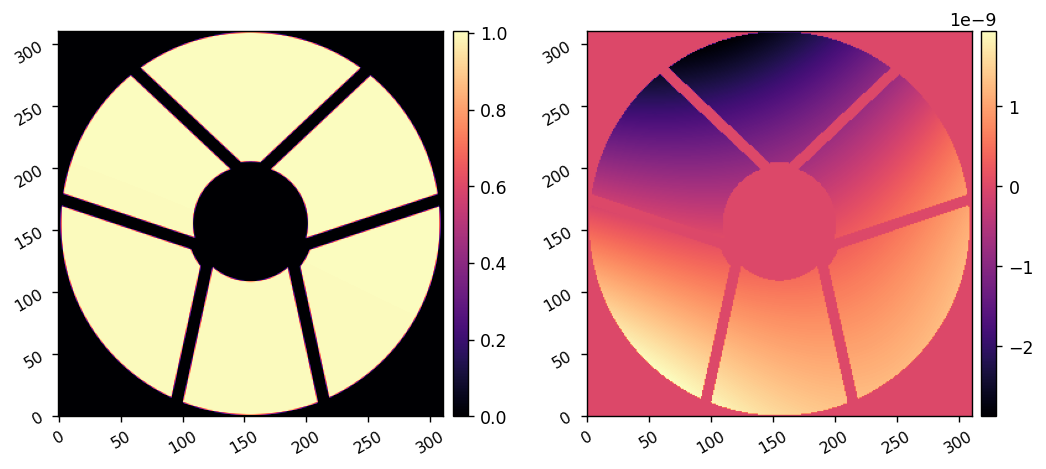

In [5]:

reload(cgi.parallelized_cgi)
mode_params.update({'polaxis':1})
actors = []
for j in range(nlam):
    actors.append(rayCGI.options(num_cpus=3).remote(wavelength=wavelengths[j], **mode_params))
hlc_0 = cgi.parallelized_cgi.ParallelizedCGI(actors)

hlc_0.set_dm1(dm1_best)
hlc_0.set_dm2(dm2_best)

polmap_0 = utils.pad_or_crop(ray.get(hlc_0.actors[2].getattr.remote('POLMAP')), npup) * pupil
polmap_0_amp = np.abs(polmap_0)
polmap_0_opd = np.angle(polmap_0) * wavelengths[2].to_value(u.m)/(2*np.pi)
imshow2(polmap_0_amp, polmap_0_opd)

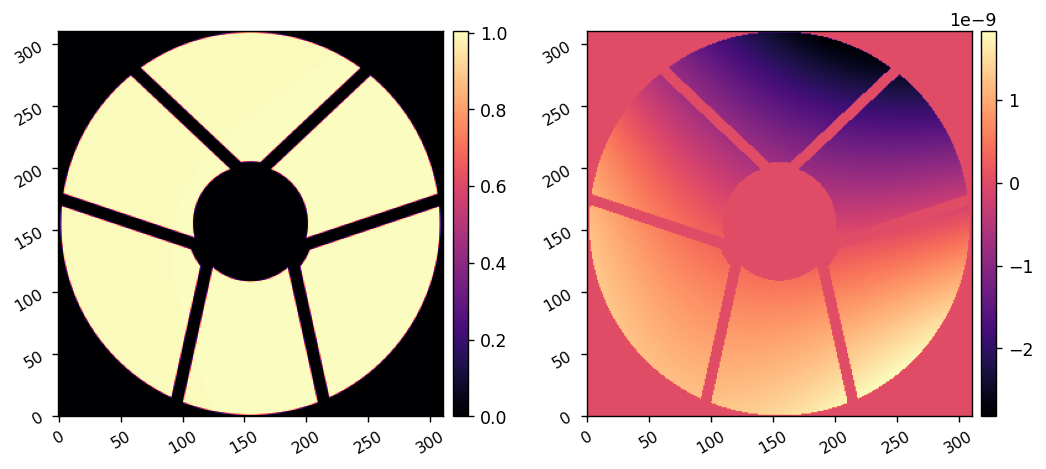

In [6]:
reload(cgi.parallelized_cgi)
mode_params.update({'polaxis':-1})
actors = []
for j in range(nlam):
    actors.append(rayCGI.options(num_cpus=3).remote(wavelength=wavelengths[j], **mode_params))
hlc_90 = cgi.parallelized_cgi.ParallelizedCGI(actors)

hlc_90.set_dm1(dm1_best)
hlc_90.set_dm2(dm2_best)

polmap_90 = utils.pad_or_crop(ray.get(hlc_90.actors[2].getattr.remote('POLMAP')), npup) * pupil
polmap_90_amp = np.abs(polmap_90)
polmap_90_opd = np.angle(polmap_90) * wavelengths[2].to_value(u.m)/(2*np.pi)
imshow2(polmap_90_amp, polmap_90_opd)

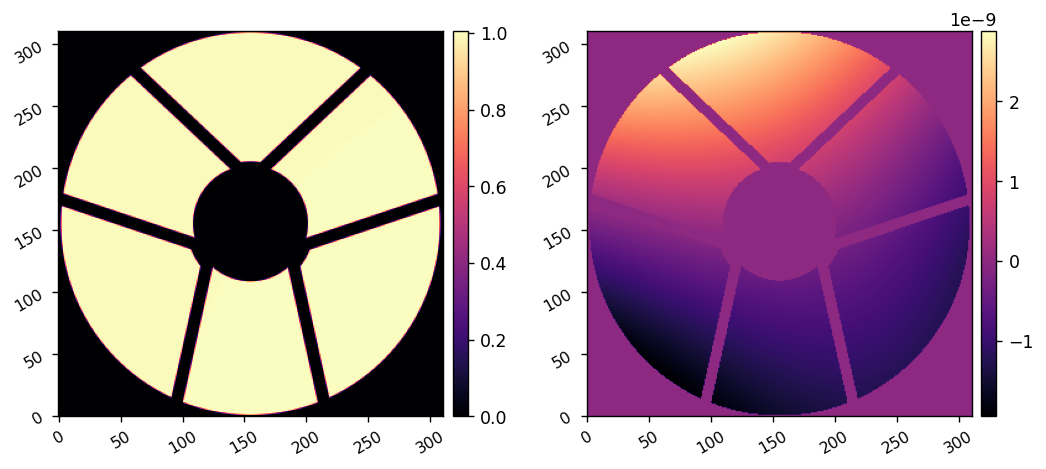

In [7]:
reload(cgi.parallelized_cgi)
mode_params.update({'polaxis':-2})
actors = []
for j in range(nlam):
    actors.append(rayCGI.options(num_cpus=3).remote(wavelength=wavelengths[j], **mode_params))
hlc_p45 = cgi.parallelized_cgi.ParallelizedCGI(actors)

hlc_p45.set_dm1(dm1_best)
hlc_p45.set_dm2(dm2_best)

polmap_p45 = utils.pad_or_crop(ray.get(hlc_p45.actors[2].getattr.remote('POLMAP')), npup) * pupil
polmap_p45_amp = np.abs(polmap_p45)
polmap_p45_opd = np.angle(polmap_p45) * wavelengths[2].to_value(u.m)/(2*np.pi)
imshow2(polmap_p45_amp, polmap_p45_opd)

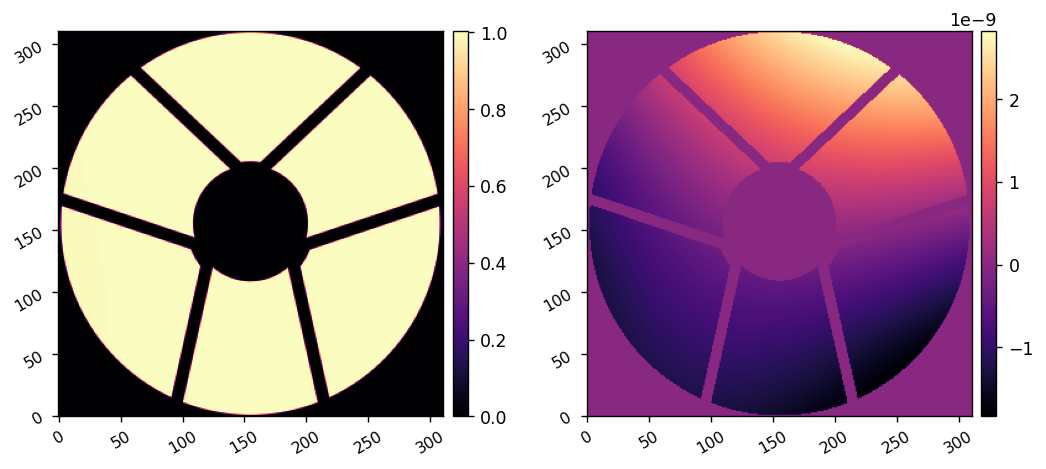

In [8]:
reload(cgi.parallelized_cgi)
mode_params.update({'polaxis':2})
actors = []
for j in range(nlam):
    actors.append(rayCGI.options(num_cpus=3).remote(wavelength=wavelengths[j], **mode_params))
hlc_n45 = cgi.parallelized_cgi.ParallelizedCGI(actors)

hlc_n45.set_dm1(dm1_best)
hlc_n45.set_dm2(dm2_best)

polmap_n45 = utils.pad_or_crop(ray.get(hlc_n45.actors[2].getattr.remote('POLMAP')), npup) * pupil
polmap_n45_amp = np.abs(polmap_n45)
polmap_n45_opd = np.angle(polmap_n45) * wavelengths[2].to_value(u.m)/(2*np.pi)
imshow2(polmap_n45_amp, polmap_n45_opd)

In [9]:
polmaps = np.array([[polmap_0, polmap_p45, ],
                    [polmap_n45, polmap_90]])

In [16]:
def Jrot(theta):
    J = np.array([[np.cos(theta), np.sin(theta)],
                   [-np.sin(theta), np.cos(theta)]])
    return J

def LR(delta, theta):
    theta = theta*np.pi/180
    lr11 = np.exp(-1j*delta/2)*np.cos(theta)**2 + np.exp(1j*delta/2)*np.sin(theta)**2
    lr12 = -1j*np.sin(delta/2)*np.sin(2*theta)
    lr21 = lr12
    lr22 = np.exp(1j*delta/2)*np.cos(theta)**2 + np.exp(-1j*delta/2)*np.sin(theta)**2
    lr = np.array([[lr11, lr12],
                   [lr21, lr22]])
    return lr


In [32]:
D = 0.004
alpha = np.sqrt((1-D)/(1+D))
alpha

0.9960079680956173

In [33]:
J_mirror = np.array([[1,0],[0,-1]])
Jrot_n45 = Jrot(-45*u.degree)
Jrot_90 = Jrot(90*u.degree)
Jret = LR(np.pi/2, -26*u.degree)
Jdiat = np.array([[1,0],[0,alpha]])

In [28]:
Jret

array([[0.70710678-0.70701807j, 0.        +0.01120018j],
       [0.        +0.01120018j, 0.70710678+0.70701807j]])

In [36]:
npix = 311

In [38]:
Jroman = np.zeros_like(polmaps)
for i in range(npix):
    for j in range(npix):
        Jroman[:,:,i,j] = J_mirror @ Jret @ Jrot_90 @ Jdiat @ polmaps[:,:,i,j] @ Jrot_n45

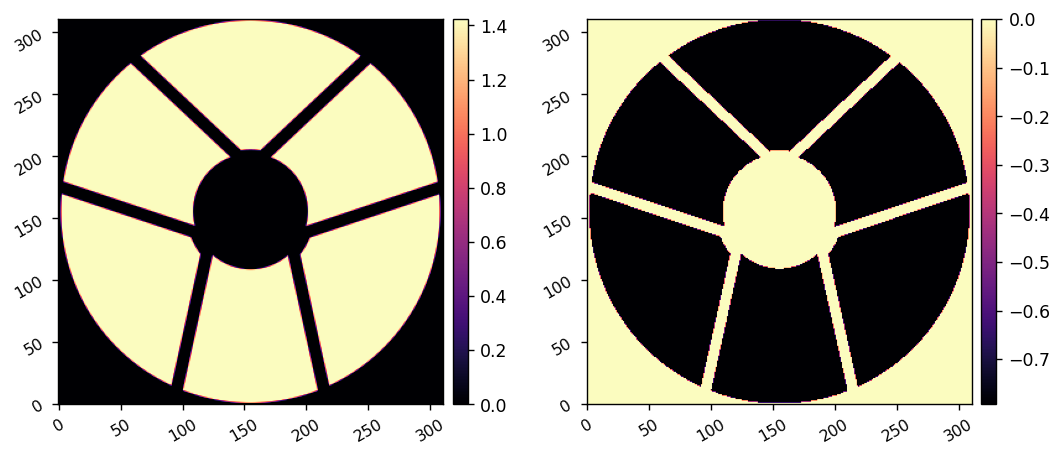

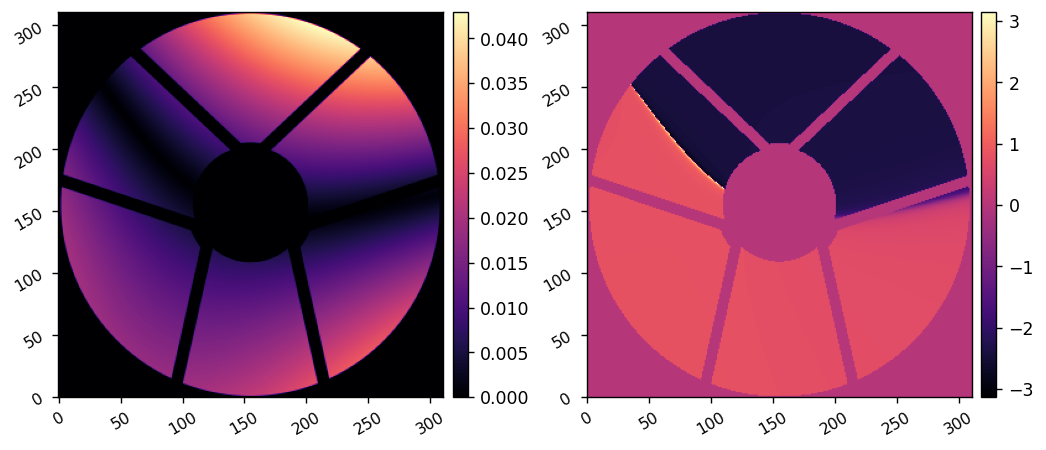

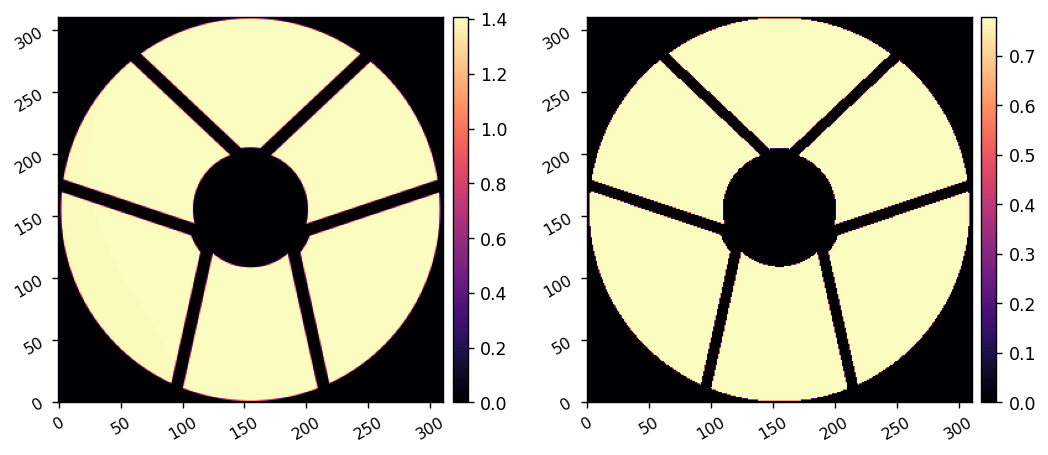

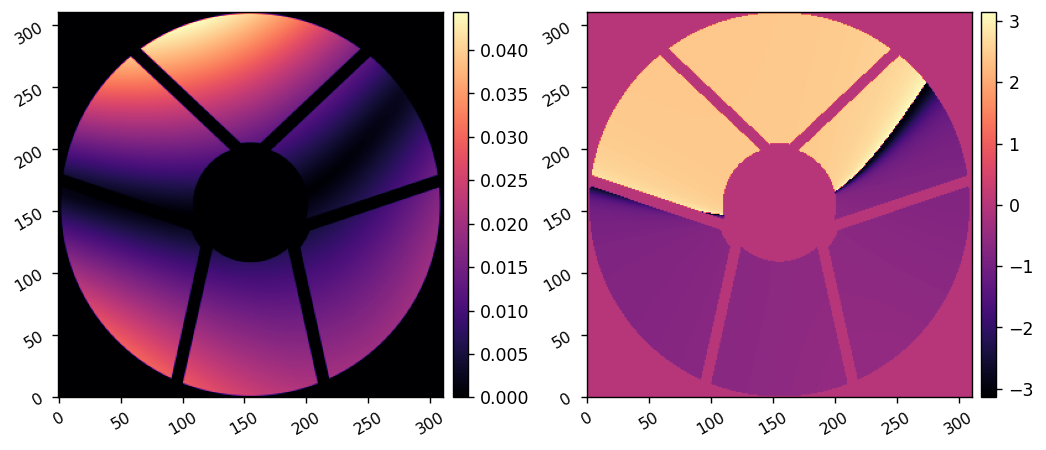

In [40]:
imshow2(np.abs(Jroman[0,0]), np.angle(Jroman[0,0]))
imshow2(np.abs(Jroman[0,1]), np.angle(Jroman[0,1]))
imshow2(np.abs(Jroman[1,0]), np.angle(Jroman[1,0]))
imshow2(np.abs(Jroman[1,1]), np.angle(Jroman[1,1]))

In [11]:
polmaps.shape

(2, 2, 311, 311)

In [8]:
im_0 = hlc_0.snap()

In [9]:
im_90 = hlc_90.snap()

In [10]:
im_p45 = hlc_p45.snap()

In [11]:
im_n45 = hlc_n45.snap()

In [12]:
total_im = (im_0 + im_90 + im_p45 + im_n45)/4

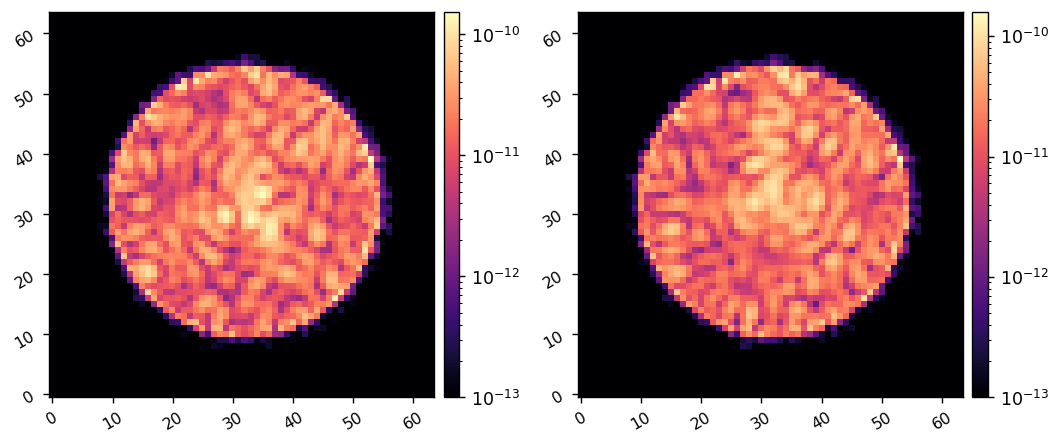

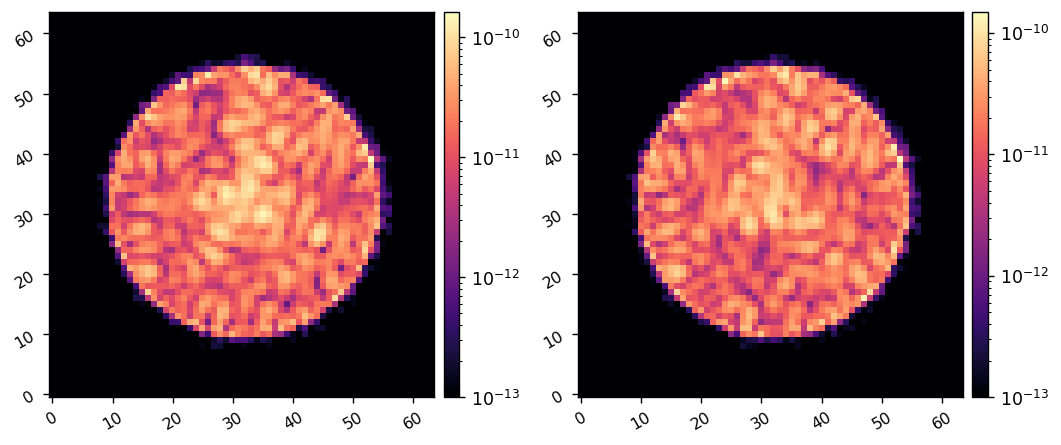

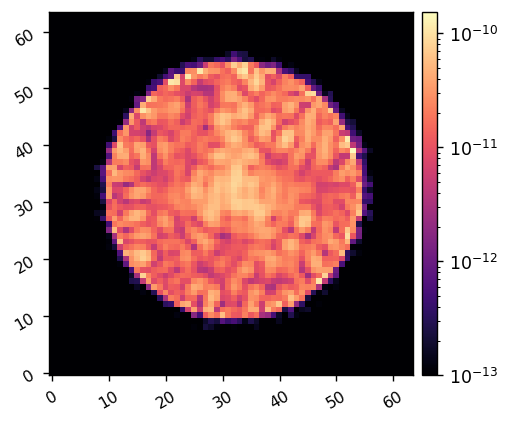

In [14]:
imshow2(im_0, im_p45, lognorm=True, vmin1=1e-13, vmin2=1e-13, )
imshow2(im_n45, im_90, lognorm=True, vmin1=1e-13, vmin2=1e-13, )
imshow1(total_im, lognorm=True, vmin=1e-13,)


In [11]:
9241*15/3600

38.50416666666667

In [14]:
hdr = fits.Header()
hdr['PXSCLAMD'] = psf_pixelscale_lamD
hdr.comments['PXSCLAMD'] = 'pixel scale in lam0/D per pixel'
hdr['PXSCLMAS'] = psf_pixelscale_mas.value
hdr.comments['PXSCLMAS'] = 'pixel scale in mas per pixel'
hdr['PIXELSCL'] = psf_pixelscale
hdr.comments['PIXELSCL'] = 'pixel scale in meters per pixel'
hdr['CWAVELEN'] = wavelength_c.to_value(u.m)
hdr.comments['CWAVELEN'] = 'central wavelength in meters'
hdr['BANDPASS'] = bandwidth
hdr.comments['BANDPASS'] = 'bandpass as fraction of CWAVELEN'

psfs_hdu = fits.PrimaryHDU(data=psfs_array, header=hdr)

psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_20230501.fits'
psfs_hdu.writeto(psfs_fpath, overwrite=True)
